In [48]:
source("../00_model-fitting/wwa_model-fitting.R")

library(copula)

In [136]:
# compute joint exceedances over regular grid for easy plotting
copula_mesh <- function(mdl_x, mdl_y, copula, cov1, xrange, yrange, n = 32) {
    
    # compute joint exceedances over regular grid for easy plotting
    
    if(missing(xrange)) xrange <- range(pretty(mdl_x$x))
    if(missing(yrange)) yrange <- range(pretty(mdl_y$x))
    
    # define the regular mesh for plotting
    x_mesh <- seq(xrange[1], xrange[2],length.out = n)
    y_mesh <- seq(yrange[1], yrange[2], length.out = n)
    
    # convert the regular mesh to U space
    x_umesh <- map_to_u(mdl_x, x_mesh, fixed_cov = cov1)
    y_umesh <- map_to_u(mdl_y, y_mesh, fixed_cov = cov1)
    
    if(substr(mdl_x$varnm,1,5) == "log10") { x_mesh <- 10^x_mesh }
    if(substr(mdl_y$varnm,1,5) == "log10") { y_mesh <- 10^y_mesh }
    
    return(list("x" = x_mesh, "y" = y_mesh, "z" = sapply(y_umesh, function(y) sapply(x_umesh, function(x) pCopula(cbind(x,y), copula)))))
}

# **Joint distribution**

In [111]:
gmst <- read.fwf("../../Data/gmst.dat", comment.char = "#", widths = c(5,15), col.names = c("year", "gmst"))

gmst_2023 <- gmst[gmst$year == 2022, "gmst"]
gmst_hist <- gmst_2023 - 1.2

In [197]:
rnm = "te" # either ir or te

# load marginal data & GMST
df = merge(gmst, merge(read.csv(paste0("ts/era_pet_", rnm, ".csv")), read.csv(paste0("ts/era_pr_", rnm, ".csv"))))

In [198]:
# check for normality
ks.test(scale(df$tp), pnorm)
ks.test(scale(df$pet), pnorm)


	Exact one-sample Kolmogorov-Smirnov test

data:  scale(df$tp)
D = 0.050991, p-value = 0.9882
alternative hypothesis: two-sided



	Exact one-sample Kolmogorov-Smirnov test

data:  scale(df$pet)
D = 0.067658, p-value = 0.8793
alternative hypothesis: two-sided


## **Choose copula form**

In [199]:
# fit marginal distributions
mdl_pr <- fit_ns("norm", "fixeddisp", df, varnm = "tp", covnm_1 = "gmst", lower = F)  # don't need to specify lower tail with MVDC, since marginals are handled simultaneously
mdl_pet <- fit_ns("norm", "shift", df, varnm = "pet", covnm_1 = "gmst", lower = F)

# transform marginals to U
u_pr <- map_to_u(mdl_pr)
u_pet <- map_to_u(mdl_pet)

### **t copula**

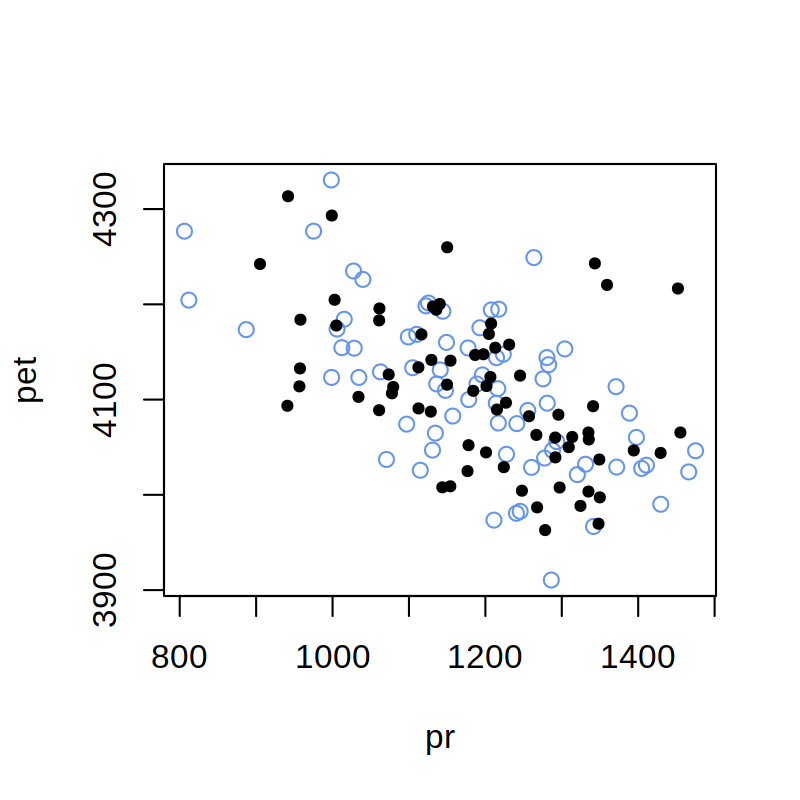

In [200]:
# fit copula to u,v pairs, generate a sample
fitted_copula <- fitCopula(tCopula(), data = cbind(u_pr, u_pet), hideWarnings = T)  # warning message about using df.fixed is irrelevant: can't actually change this setting

fitted_mvdc <- mvdc(copula = tCopula(coef(fitted_copula)["rho.1"], df = round(coef(fitted_copula)["df"], 0)), 
                    margins=c("norm", "norm"), paramMargins=list(list(mean=mean(df$tp), sd=sd(df$tp)), list(mean=mean(df$pet), sd=sd(df$pet))))

set.seed(42)
mvsamp <- rMvdc(nrow(df), fitted_mvdc)
colnames(mvsamp) <- c("pr", "pet")

plot(mvsamp, col = "cornflowerblue")
points(df$tp, df$pet, pch = 20, col = "black")

## **Fit chosen model & get contour values**

In [211]:
# fit marginal distributions
mdl_pr <- fit_ns("norm", "fixeddisp", df, varnm = "tp", covnm_1 = "gmst", lower = T)
mdl_pet <- fit_ns("norm", "shift", df, varnm = "pet", covnm_1 = "gmst", lower = F)

# transform marginals to U
u_pr <- map_to_u(mdl_pr)
u_pet <- map_to_u(mdl_pet)

fitted_copula <- fitCopula(tCopula(), data = cbind(u_pr, u_pet), hideWarnings = T)  # warning message about using df.fixed is irrelevant: can't actually change this setting
cfit <- tCopula(coef(fitted_copula)["rho.1"], df = round(coef(fitted_copula)["df"], 0))

In [212]:
# get return levels in factual & counterfactual climates
rl_pr <- list("2023" = mdl_pr$ev, "hist" = map_from_u(map_to_u(mdl_pr, mdl_pr$ev, gmst_2023), mdl_pr, gmst_hist))
rl_pet <- list("2023" = mdl_pet$ev, "hist" = map_from_u(map_to_u(mdl_pet, mdl_pet$ev, gmst_2023), mdl_pet, gmst_hist))

# joint exceedance probabilities
joint_ep <- list("2023" = 1/pCopula(c(map_to_u(mdl_pr, mdl_pr$ev, gmst_2023), map_to_u(mdl_pet, mdl_pet$ev, gmst_2023)), cfit),
                 "hist" = 1/pCopula(c(map_to_u(mdl_pr, mdl_pr$ev, gmst_hist), map_to_u(mdl_pet, mdl_pet$ev, gmst_hist)), cfit))

# and check using those PI marginals - should give the same joint return period
1/pCopula(c(map_to_u(mdl_pr, rl_pr$"hist", gmst_hist), map_to_u(mdl_pet, rl_pet$"hist", gmst_hist)), cfit)

xrng <- list("ir" = c(800, 1400), "te" = c(800, 1400))[[rnm]]
yrng <- list("ir" = c(4000, 4350), "te" = c(4000, 4350))[[rnm]]

cmesh_2023 <- copula_mesh(mdl_pr, mdl_pet, cfit, gmst_2023, yrange = yrng, xrange = xrng)
cmesh_hist <- copula_mesh(mdl_pr, mdl_pet, cfit, gmst_hist, yrange = yrng, xrange = xrng)

[1] 83.93377

### **Contour plot**

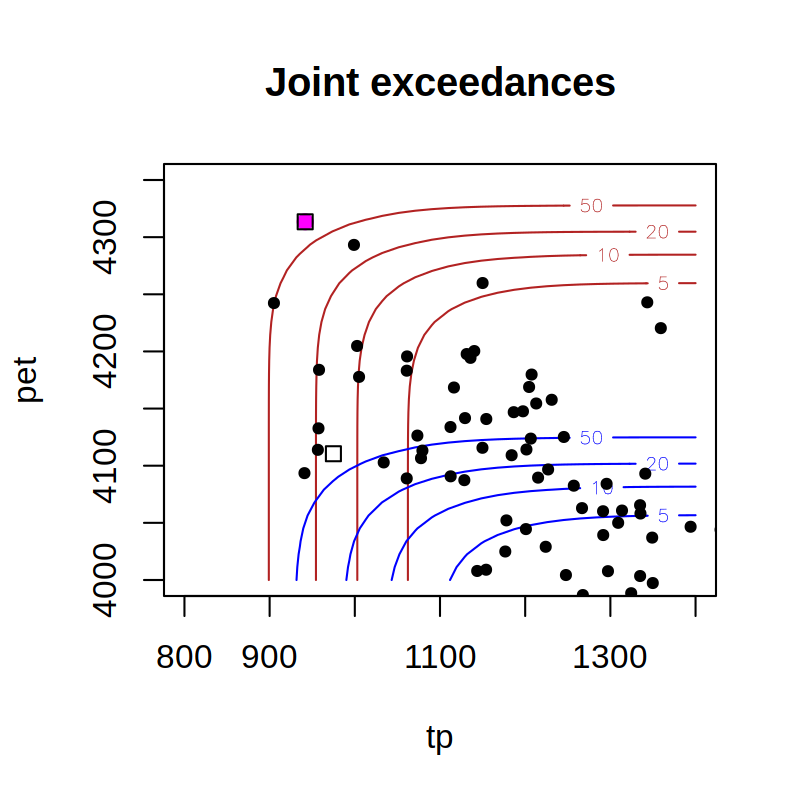

In [213]:
# check that plot region covers all contours & features of interest

prep_window(c(1,1))

contour(cmesh_2023, levels = 1/c(5,10,20,50), labels = c(5,10,20,50), col = "firebrick",
        main = "Joint exceedances", xlab = mdl_pr$varnm, ylab = mdl_pet$varnm)

contour(cmesh_hist, levels = 1/c(5,10,20,50), labels = c(5,10,20,50), col = "blue", add = T)

points(mdl_pr$x, mdl_pet$x, pch = 20)
points(mdl_pr$ev, mdl_pet$ev, pch = 20, col = "magenta", cex = 1.5)

points(rl_pr$"2023", rl_pet$"2023", pch = 0)
points(rl_pr$"hist", rl_pet$"hist", pch = 0)

### **Save contours for transfer to python**

In [214]:
require(jsonlite)

contours <- list("coef" = coef(fitted_copula), 
                 "rl_pr" = rl_pr,
                 "rl_pet" = rl_pet,
                 "current" = cmesh_2023, 
                 "cf" = cmesh_hist,
                 "joint_ep" = joint_ep)
write_json(contours, paste0("joint-fit_era5_pr-pet_",rnm,".json"))